# Fish 이미지 분류
https://www.kaggle.com/crowww/a-large-scale-fish-dataset

In [127]:
import numpy as np 
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, GlobalMaxPool2D, GlobalAvgPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

In [117]:
addr = Path('D:/prac/fish_classification/Fish_Dataset')
filepath = list(addr.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepath))

filepath = pd.Series(filepath, name='FilePaths').astype(str)
labels = pd.Series(labels, name='Labels').astype(str)

df_imgs = pd.merge(filepath, labels, right_index = True, left_index = True)
df_imgs = df_imgs[df_imgs['Labels'].apply(lambda x: x[-2:]!='GT') ]

df_imgs=df_imgs.sample(frac = 1).reset_index(drop=True)
df_imgs

,FilePaths,Labels
0,D:\prac\fish_classification\Fish_Dataset\Fish_...,Trout
1,D:\prac\fish_classification\Fish_Dataset\Fish_...,Red Mullet
2,D:\prac\fish_classification\Fish_Dataset\Fish_...,Hourse Mackerel
3,D:\prac\fish_classification\Fish_Dataset\Fish_...,Red Sea Bream
4,D:\prac\fish_classification\Fish_Dataset\Fish_...,Red Sea Bream
...,...,...
8995,D:\prac\fish_classification\Fish_Dataset\Fish_...,Striped Red Mullet
8996,D:\prac\fish_classification\Fish_Dataset\Fish_...,Shrimp
8997,D:\prac\fish_classification\Fish_Dataset\Fish_...,Red Sea Bream
8998,D:\prac\fish_classification\Fish_Dataset\Fish_...,Red Sea Bream


In [118]:
df_imgs['Labels'].value_counts(ascending=True)

Trout                 1000
Red Mullet            1000
Hourse Mackerel       1000
Red Sea Bream         1000
Sea Bass              1000
Gilt-Head Bream       1000
Shrimp                1000
Striped Red Mullet    1000
Black Sea Sprat       1000
Name: Labels, dtype: int64

In [119]:
X_train, X_test = train_test_split(df_imgs, test_size=0.3)
X_val, X_test = train_test_split(X_test, test_size=0.15/0.3) 

In [120]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(6300, 2)
(1350, 2)
(1350, 2)


In [121]:
img_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

In [132]:
X_train = img_generator.flow_from_dataframe(dataframe = X_train, 
                                          x_col='FilePaths', 
                                          y_col='Labels', 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=48,
                                          seed=33)

X_test = img_generator.flow_from_dataframe(dataframe = X_test, 
                                         x_col='FilePaths', 
                                         y_col='Labels', 
                                         target_size=(224,224),
                                         color_mode='rgb',
                                         class_mode='categorical',
                                         batch_size=48,
                                         seed=33)

X_val = img_generator.flow_from_dataframe(dataframe = X_val, 
                                        x_col='FilePaths', 
                                        y_col='Labels', 
                                        target_size=(224,224), 
                                        color_mode='rgb',
                                        class_mode='categorical',
                                        batch_size=48,
                                        seed=33)

Found 6300 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.


In [133]:
base_model = EfficientNetB0(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(9,activation='softmax'))

In [134]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
dropout_12 (Dropout)         (None, 7, 7, 1280)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 62720)             0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 62720)             250880    
_________________________________________________________________
dense_10 (Dense)             (None, 512)               32113152  
_________________________________________________________________
batch_normalization_9 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)              

In [137]:
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy',Precision(),Recall(),AUC()],
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

filepath = './best_weights.hdf5'
es = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 5,
                              verbose = 1)

mc = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

#lr_schedule = ReduceLROnPlateau(monitor='val_loss', mode='min', patience='5', verbose=1)

In [140]:
with tf.device('/GPU:0'):
    history = model.fit(X_train,            
                        validation_data=X_val,
                        steps_per_epoch=5,
                        epochs = 20,
                        callbacks = [es, mc],
                        verbose = 1,
                        )

Epoch 1/20
5/5 [==============================] - 16s 4s/step - loss: 0.3375 - accuracy: 0.8833 - precision_4: 0.8932 - recall_4: 0.8708 - auc_4: 0.9902 - val_loss: 1.2995 - val_accuracy: 0.8593 - val_precision_4: 0.8603 - val_recall_4: 0.8578 - val_auc_4: 0.9511

Epoch 00001: val_accuracy improved from -inf to 0.85926, saving model to .\best_weights.hdf5
Epoch 2/20
5/5 [==============================] - 10s 2s/step - loss: 0.4138 - accuracy: 0.8750 - precision_4: 0.8787 - recall_4: 0.8750 - auc_4: 0.9861 - val_loss: 0.7248 - val_accuracy: 0.8970 - val_precision_4: 0.8983 - val_recall_4: 0.8963 - val_auc_4: 0.9698

Epoch 00002: val_accuracy improved from 0.85926 to 0.89704, saving model to .\best_weights.hdf5
Epoch 3/20
5/5 [==============================] - 10s 2s/step - loss: 0.2762 - accuracy: 0.8833 - precision_4: 0.8936 - recall_4: 0.8750 - auc_4: 0.9954 - val_loss: 0.3721 - val_accuracy: 0.9370 - val_precision_4: 0.9370 - val_recall_4: 0.9370 - val_auc_4: 0.9848

Epoch 00003: val

In [141]:
test_accuracy = model.evaluate(x_test)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

29/29 [==============================] - 12s 417ms/step - loss: 0.0208 - accuracy: 0.9919 - precision_4: 0.9926 - recall_4: 0.9919 - auc_4: 1.0000
Test accuracy is :  99.18518662452698 %


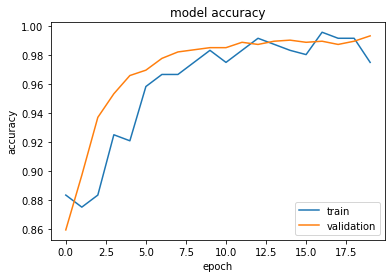

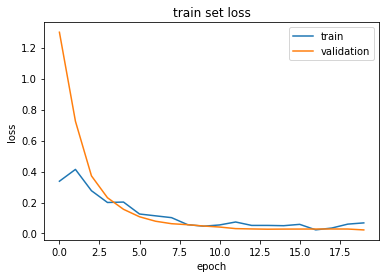

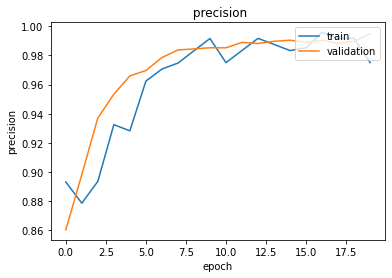

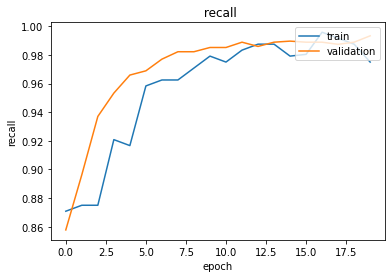

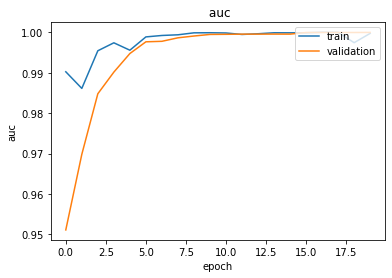

In [145]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train set loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['precision_4'])
plt.plot(history.history['val_precision_4'])
plt.title(' precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


plt.plot(history.history['recall_4'])
plt.plot(history.history['val_recall_4'])
plt.title(' recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['auc_4'])
plt.plot(history.history['val_auc_4'])
plt.title(' auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [155]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(x_test)
print('Test Accuracy : {:.5f}'.format(test_accuracy))
print('Test loss     : {:.5f}'.format(test_loss))
print('Test Precision: {:.5f}'.format(test_precision))
print('Test Recall   : {:.5f}'.format(test_recall))
print('Test auc      : {:.5f}'.format(test_auc))

29/29 [==============================] - 8s 269ms/step - loss: 0.0208 - accuracy: 0.9919 - precision_4: 0.9926 - recall_4: 0.9919 - auc_4: 1.0000
Test Accuracy : 0.99185
Test loss     : 0.02077
Test Precision: 0.99259
Test Recall   : 0.99185
Test auc      : 0.99996
